Crossmatching tests
========

In the jupyter docker images, this requires running `pip install esutil astropy` in a terminal first.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from esutil.htm import HTM

plt.rc('figure', dpi=120)

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

sc = SparkContext('local[*]')
sc.setLogLevel("WARN")

spark = SparkSession(sc)

In [105]:
%%time

def make_measurements(input_id):
    
    #n_objects = np.random.poisson(200)
    n_objects = 10000
    sample_rate = 10
    obj_ra = 30*np.random.rand(n_objects)
    obj_dec = 30*np.random.rand(n_objects)
    
    randomize_counts = False
    if randomize_counts:
        sel_obj = np.random.choice(np.arange(len(obj_ra)), n_objects*sample_rate)
    else:
        sel_obj = np.arange(len(obj_ra)).repeat(sample_rate)
    
    source_ids = input_id*1000 + np.arange(len(sel_obj))
    source_ra = obj_ra[sel_obj] + 1/3600.0*np.random.randn(len(sel_obj)) #.clip(-2, 2)
    source_dec = obj_dec[sel_obj] + 1/3600.0*np.random.randn(len(sel_obj)) #.clip(-2, 2)

    # This is gross, but we have to return native python numeric types.
    return ((a.item(), b.item(), c.item()) for (a,b,c) in zip(source_ids, source_ra, source_dec))
    
raw_sources = sc.range(1).flatMap(make_measurements)
spark.createDataFrame(raw_sources, schema=("source_id", "ra", "dec")).createOrReplaceTempView("raw_sources")

CPU times: user 30 ms, sys: 0 ns, total: 30 ms
Wall time: 121 ms


In [106]:
%%time
def add_htmid(object_tuple):
    htm_obj = HTM(depth=3)
    source_id, ra, dec = object_tuple
    htm_id = htm_obj.lookup_id(ra, dec)
    return htm_id.item()

grouped_rdd = raw_sources.keyBy(add_htmid).groupByKey()

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 37.5 ms


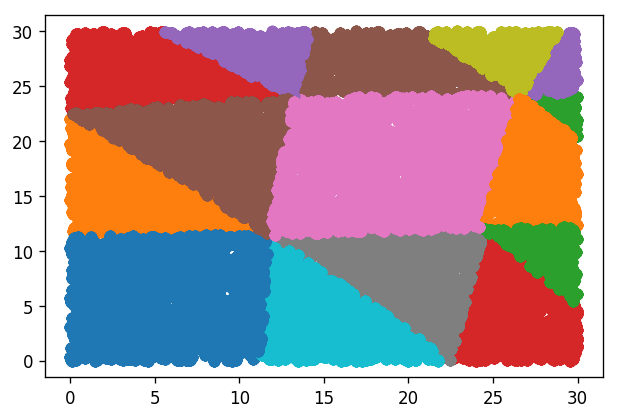

In [85]:
for id, values in grouped_rdd.collect():
    plt.plot([x[1] for x in values],
             [x[2] for x in values], 'o')

In [128]:
def match_sources(iterator):
    htm_id, values = iterator
    
    input_dict = {k: v for (k, v) in zip(range(len(values)), values)}
    source_ids = np.array([x[0] for x in values])
    ra = np.array([x[1] for x in values])
    dec = np.array([x[2] for x in values])

    tree = cKDTree(np.stack((ra, dec), axis=1))

    candidate_groups = []
    # First pass, just to get groupings
    for this_id in range(len(ra)):
        dists, idx = tree.query( (ra[this_id], dec[this_id]), k=15, distance_upper_bound=4/3600.0)
        sel, = np.where((dists < 3/3600.0) & (idx != this_id))
        found_source_ids = source_ids[idx[sel]]
        this_group = [input_dict[this_id]]
        for n in idx[sel]:
            this_group.append((input_dict[n]))
        candidate_groups.append(this_group)
    
    # Second pass uses the mean position of the sources in each group, then re-matches
    # This potentially matches sources into multiple objects
    output_groups = []
    for candidate_group in candidate_groups:
        mean_ra = np.mean(np.array([x[1] for x in candidate_group]))
        mean_dec = np.mean(np.array([x[2] for x in candidate_group]))        
        dists, idx = tree.query( (mean_ra, mean_dec), k=15, distance_upper_bound=4/3600.0)
        sel, = np.where((dists < 3/3600.0))
        found_source_ids = source_ids[idx[sel]]
        this_group = []
        for n in idx[sel]:
            this_group.append((input_dict[n]))
        output_groups.append(this_group)
    return output_groups

        
def single_pass_match_sources(iterator):
    htm_id, values = iterator
    
    input_dict = {k: v for (k, v) in zip(range(len(values)), values)}
    source_ids = np.array([x[0] for x in values])
    ra = np.array([x[1] for x in values])
    dec = np.array([x[2] for x in values])

    tree = cKDTree(np.stack((ra, dec), axis=1))

    candidate_ids = set(range(len(ra)))    
    while candidate_ids:
        this_id = candidate_ids.pop()
        dists, idx = tree.query( (ra[this_id], dec[this_id]), k=15, distance_upper_bound=4/3600.0)
        sel, = np.where((dists < 3/3600.0) & (idx != this_id))
        found_source_ids = source_ids[idx[sel]]
        this_group = [input_dict[this_id]]
        for n in idx[sel]:
            candidate_ids.discard(n)

            this_group.append((input_dict[n]))
        output_groups.append(this_group)

    return output_groups


In [129]:
def apply_obj_id(input):
    iterator, obj_id = input
    return [(obj_id,) + values for values in iterator]

# This flattens the per-htm partitioning
matched_groups = grouped_rdd.map(match_sources).flatMap(lambda x: x).zipWithUniqueId()

# This flattens the objects back into sources, but prepends the obj_id to each src record
tagged_source_records = matched_groups.flatMap(apply_obj_id)
source_table = spark.createDataFrame(tagged_source_records, schema=("obj_id", "source_id", "ra", "dec"))
source_table.createOrReplaceTempView("source_table")

In [130]:
summary_table = spark.sql("SELECT obj_id, mean(ra) as ra, mean(dec) as dec, count(*) as n_epochs "
                             "FROM source_table GROUP BY obj_id")
summary_table.createOrReplaceTempView("summary_table")

In [135]:
summary_table.limit(10).toPandas()

,obj_id,ra,dec,n_epochs
0,26,3.940095,4.896385,10
1,474,4.764050,5.387329,10
2,964,8.101457,2.312125,10
3,1806,1.551754,7.890223,10
4,1950,6.530625,2.129634,10
5,2040,5.218388,2.634361,10
6,2214,5.044720,2.461655,10
7,2250,0.322978,0.278424,10
8,3506,7.897949,1.680747,10
9,3764,4.881194,1.338780,10


In [131]:
spark.sql("SELECT mean(n_epochs) FROM summary_table").toPandas()

,avg(n_epochs)
0,9.81468


In [132]:
query = "WHERE ra > 3.7 AND ra < 4.2 AND dec > 4.7 AND dec < 5.1"
zoomed_src = spark.sql("SELECT ra, dec FROM raw_sources " + query).toPandas()
#plt.plot(zoomed_src['ra'], zoomed_src['dec'], 'o', ms=3)

zoomed_obj = spark.sql("SELECT ra, dec FROM summary_table " + query).toPandas()
#plt.plot(zoomed_obj['ra'], zoomed_obj['dec'], 'o', ms=5)



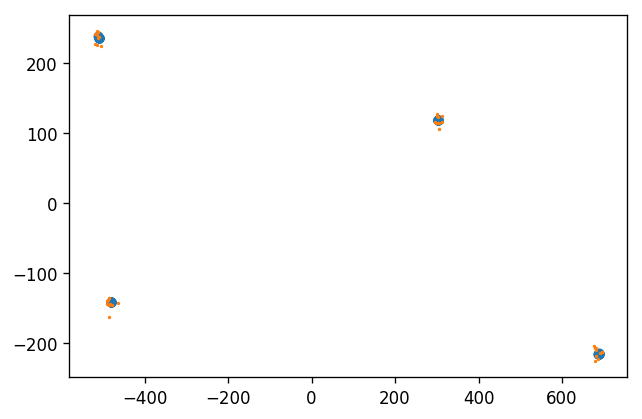

In [133]:
ra_zeropoint = np.mean(zoomed_src['ra'])
dec_zeropoint = np.mean(zoomed_src['dec']) 
delta_ra = zoomed_src['ra'] - ra_zeropoint + 7/3600.0*np.random.randn(len(zoomed_src))
delta_dec = zoomed_src['dec'] - dec_zeropoint + 7/3600.0*np.random.randn(len(zoomed_src))



plt.plot(3600*(zoomed_obj['ra'] - ra_zeropoint), 3600*(zoomed_obj['dec'] - dec_zeropoint), 'o', ms=5)
plt.plot(delta_ra*3600.0, delta_dec*3600.0, 'o', ms=1)

In [93]:
len(zoomed_src), len(zoomed_obj)

(10, 10)

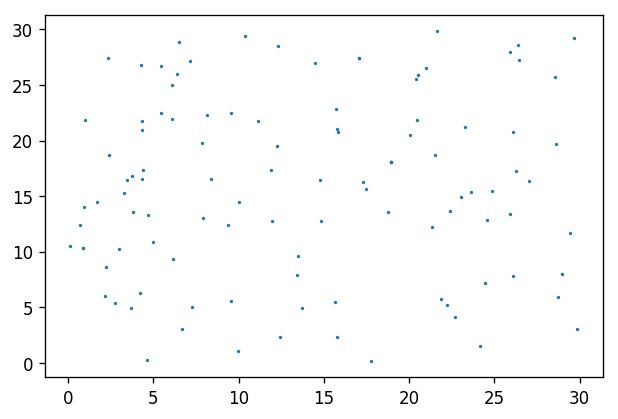

In [134]:
few_epochs = spark.sql("SELECT ra, dec FROM summary_table WHERE n_epochs < 5").toPandas()

plt.plot(few_epochs['ra'], few_epochs['dec'], 'o', ms=1)

In [13]:
len(few_epochs)

70143